In [73]:
import numpy as np
import random
import cv2 as cv
from skimage import filters
from skimage.feature import corner_peaks
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 500

In [74]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [75]:
def CornerResponse(img, window, sigma, alpha):
    Ix = filters.sobel_v(img)
    Iy = filters.sobel_h(img)
    ker = cv.getGaussianKernel(window, sigma = sigma)
    Ixx = cv.filter2D(Ix ** 2, -1, ker)
    Ixy = cv.filter2D(Ix * Iy, -1, ker)
    Iyy = cv.filter2D(Iy ** 2, -1, ker)
    response = (Ixx * Iyy - Ixy ** 2) - alpha * (Ixx + Iyy) ** 2
    return response

def HarrisCornerDetector(img, window = 5, sigma = 2, alpha = 0.05, threshold = 0.05):
    response = CornerResponse(img, window, sigma, alpha)
    return corner_peaks(response, threshold_rel = threshold)

In [76]:
def NormalizedCorrelation(img1, x1, y1, img2, x2, y2, r):
    batch1 = img1[x1 - r : x1 + r + 1, y1 - r : y1 + r + 1]
    mu1 = np.mean(batch1)
    sigma1 = np.std(batch1)
    batch2 = img2[x2 - r : x2 + r + 1, y2 - r : y2 + r + 1]
    mu2 = np.mean(batch2)
    sigma2 = np.std(batch2)
    n = (2 * r - 1) ** 2
    corr = np.sum(((batch1 - mu1) / sigma1) * ((batch2 - mu2) / sigma2)) / n
    return corr

def FindMatchingPairs(img1, corners1, img2, corners2, r, threshold):
    h, w = img1.shape
    m, _ = corners1.shape
    n, _ = corners2.shape
    PointSet1 = []
    PointSet2 = []
    for i in range(m):
        if r <= corners1[i, 0] <= h - r - 1 and r <= corners1[i, 1] <= w - r - 1:
            for j in range(n):
                if r <= corners2[j, 0] <= h - r - 1 and r <= corners2[j, 1] <= w - r - 1:
                    if NormalizedCorrelation(img1, corners1[i, 0], corners1[i, 1], img2, corners2[j, 0], corners2[j, 1], r) > threshold:
                        PointSet1.append(corners1[i])
                        PointSet2.append(corners2[j])
    PointSet1 = np.array(PointSet1)
    PointSet2 = np.array(PointSet2)
    return PointSet1, PointSet2

In [77]:
def ComputeHomographyMatrix(PointSet1, PointSet2):
    m = len(PointSet1)
    A = np.zeros((2 * m, 9))
    for i in range(m):
        A[2 * i, :] = [PointSet1[i][0], PointSet1[i][1], 1, 0, 0, 0, -PointSet2[i][0] * PointSet1[i][0], -PointSet2[i][0] * PointSet1[i][1], -PointSet2[i][0]]
        A[2 * i + 1, :] = [0, 0, 0, PointSet1[i][0], PointSet1[i][1], 1, -PointSet2[i][1] * PointSet1[i][0], -PointSet2[i][1] * PointSet1[i][1], -PointSet2[i][1]]
    _, _, V = np.linalg.svd(A)
    H = np.reshape(V[-1, :], (3, 3))
    return H

In [78]:
def RANSAC(PointSet1, PointSet2, iteration = 500, threshold = 1):
    n = len(PointSet1)
    population = range(n)
    max_inliers = 0
    bestSet = []
    for _ in range(iteration):
        inliers = 0
        sample = random.sample(population, 4)
        Satisfied = sample
        H = ComputeHomographyMatrix(PointSet1[sample], PointSet2[sample])
        for i in range(n):
            [x1, y1] = PointSet1[i]
            [x2, y2, z2] = np.dot(H, np.array([x1, y1, 1]).T)
            [x2, y2] = [x2, y2] / z2
            if np.linalg.norm([x2, y2] - PointSet2[i]) < threshold:
                inliers += 1
                Satisfied.append(i)
        if inliers > max_inliers:
            max_inliers = inliers
            bestSet = Satisfied
    H = ComputeHomographyMatrix(PointSet1[bestSet], PointSet2[bestSet])
    return H, bestSet

In [82]:
img1 = cv.imread('MelakwaLake1.png')
img1_gray = rgb2gray(img1)
corners1 = HarrisCornerDetector(img1_gray, threshold = 0.05)

img2 = cv.imread('MelakwaLake2.png')
img2_gray = rgb2gray(img2)
corners2 = HarrisCornerDetector(img2_gray, threshold = 0.05)

PointSet1, PointSet2 = FindMatchingPairs(img1_gray, corners1, img2_gray, corners2, r = 6, threshold = 0.999)

In [83]:
H, bestFitSet = RANSAC(PointSet1, PointSet2)
PointSet1 = PointSet1[bestFitSet]
PointSet2 = PointSet2[bestFitSet]

(-0.5, 443.5, 591.5, -0.5)

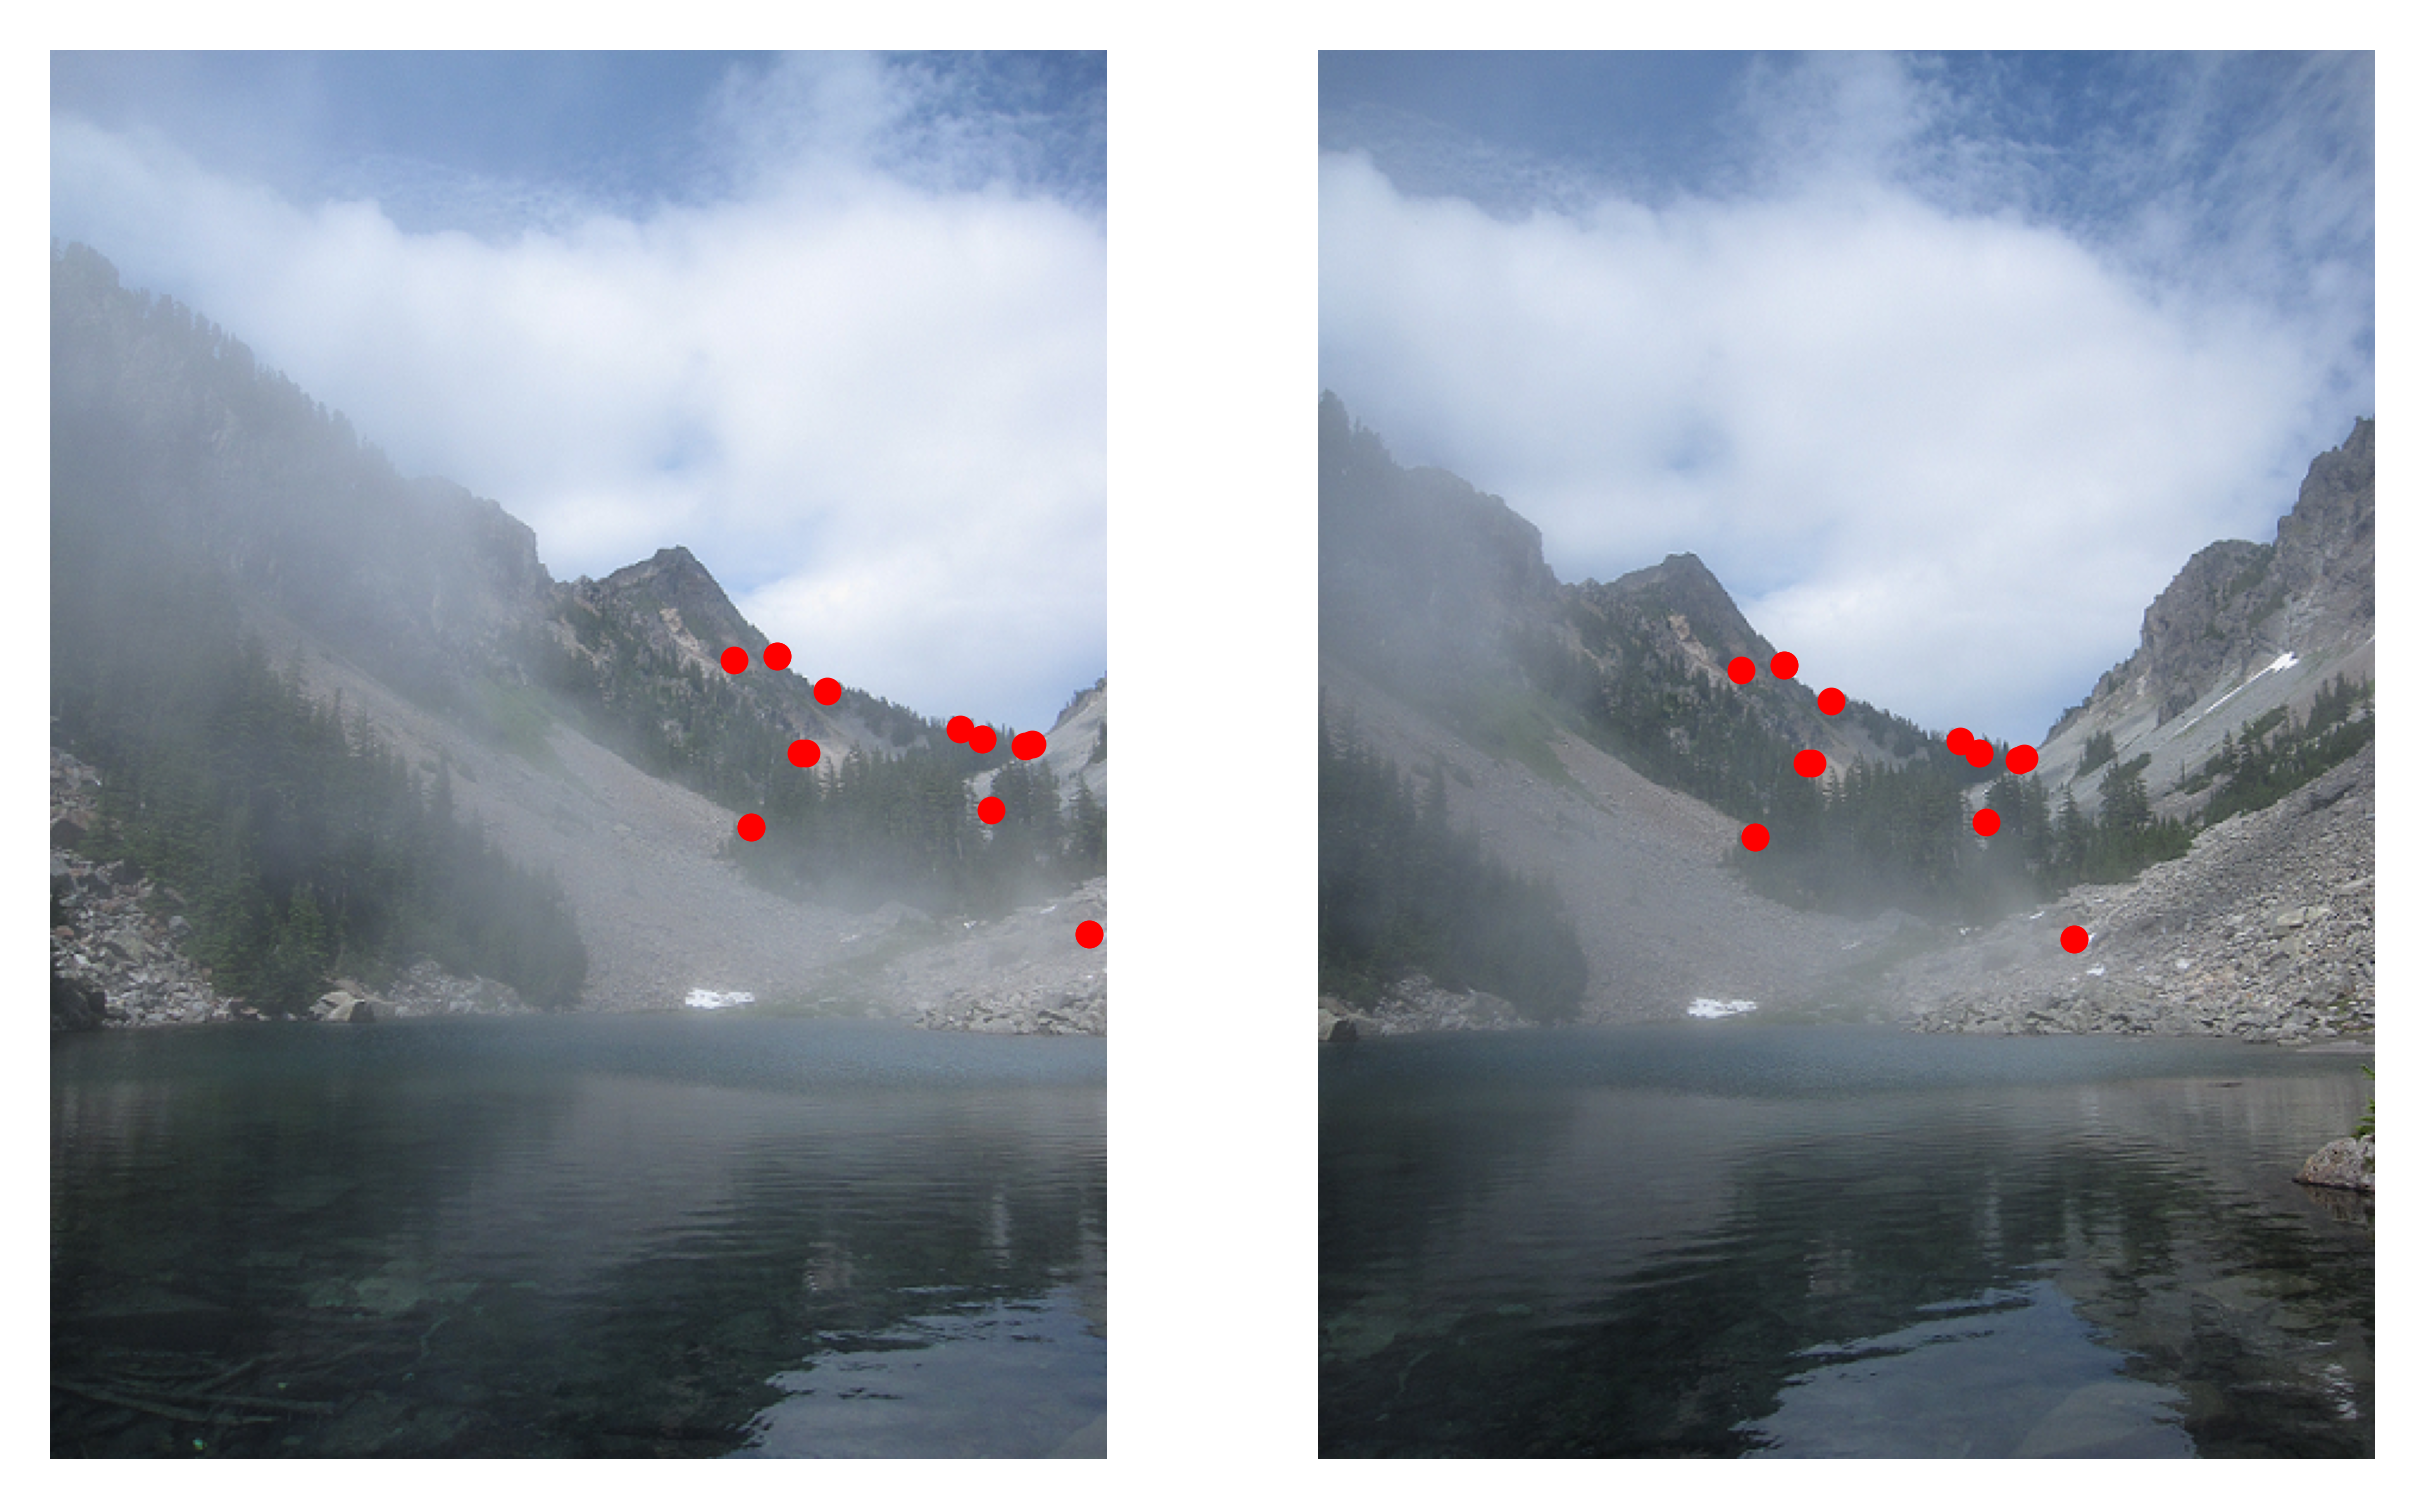

In [84]:
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
for i in range(len(PointSet1)):
    plt.scatter(PointSet1[i, 1], PointSet1[i, 0], marker = '.', c = "red")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
for i in range(len(PointSet2)):
    plt.scatter(PointSet2[i, 1], PointSet2[i, 0], marker = '.', c = "red")
plt.axis('off')